# Imbalanced Data Model

This notebook contains implementation regarding a model trained to classify behavioral biometric scripts using an imbalanced dataset with more negatives than positives. The intent here is to replicate the actual setting where there are generally less behavioral biometric scripts on the web to be found.

## Imports

In [34]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, 
                           roc_curve, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Environment setup complete!")


Environment setup complete!


## Load From DB

In [35]:
# Cell 2: Load and Prepare Data
def load_data_from_db():
    """Load data from PostgreSQL database"""
    try:
        conn = psycopg2.connect(
            host="localhost",
            port=5434,
            database="vv8_backend",
            user="vv8",
            password="vv8"
        )
        query = "SELECT * FROM multicore_static_info_known_companies"
        df = pd.read_sql(query, conn)
        conn.close()
        print(f"Loaded {len(df)} scripts from database")
        return df
    except Exception as e:
        print(f"Database connection failed: {e}")
        print("Please ensure your database is running and credentials are correct")
        return None

# Load your data (replace with your actual loading method)
df = load_data_from_db()

if df is None:
    print("Using your existing dataframe...")
    # Assuming you already have 'df' loaded from your previous cells
    pass


Loaded 2229 scripts from database


## Dataset Analysis

In [36]:
# Cell 3: Data Analysis and Preparation
def analyze_dataset(df):
    """Comprehensive analysis of the dataset"""
    print("="*60)
    print("DATASET ANALYSIS")
    print("="*60)
    
    # Basic statistics - handle 3-class problem
    print(f"Total scripts: {len(df)}")
    print(f"Original label distribution:")
    print(f"  Label 1 (positive): {len(df[df['label'] == 1])}")
    print(f"  Label 0 (negative): {len(df[df['label'] == 0])}")
    print(f"  Label -1 (negative): {len(df[df['label'] == -1])}")
    
    # Convert to binary problem: 1 = positive, (0 and -1) = negative
    df_binary = df.copy()
    df_binary['label'] = (df_binary['label'] == 1).astype(int)
    
    positive_count = len(df_binary[df_binary['label'] == 1])
    negative_count = len(df_binary[df_binary['label'] == 0])
    
    print(f"\nBinary conversion:")
    print(f"  Positive (1): {positive_count}")
    print(f"  Negative (0 + -1): {negative_count}")
    print(f"  Class balance ratio: {positive_count / negative_count:.3f}")
    print(f"  Class imbalance ratio: {negative_count / positive_count:.1f}:1")
    
    # Vendor analysis (positives only)
    positive_df = df_binary[df_binary['label'] == 1].copy()
    
    if 'vendor' in positive_df.columns:
        vendor_counts = positive_df['vendor'].value_counts()
        print(f"\nVendor Distribution (Positive Scripts):")
        print(vendor_counts)
        
        # Categorize vendors by sample size
        high_volume = vendor_counts[vendor_counts > 20].index.tolist()
        medium_volume = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
        low_volume = vendor_counts[vendor_counts < 5].index.tolist()
        
        print(f"\nVendor Categories:")
        print(f"High volume (>20): {len(high_volume)} vendors - {high_volume}")
        print(f"Medium volume (5-20): {len(medium_volume)} vendors - {medium_volume}")
        print(f"Low volume (<5): {len(low_volume)} vendors - {low_volume}")
        
        return {
            'binary_df': df_binary,  # Return the converted dataframe
            'total_scripts': len(df_binary),
            'positive_scripts': len(positive_df),
            'negative_scripts': len(df_binary[df_binary['label'] == 0]),
            'vendor_counts': vendor_counts,
            'high_volume_vendors': high_volume,
            'medium_volume_vendors': medium_volume,
            'low_volume_vendors': low_volume
        }
    else:
        print("No vendor column found - using binary classification only")
        return {
            'binary_df': df_binary,  # Return the converted dataframe
            'total_scripts': len(df_binary),
            'positive_scripts': len(positive_df),
            'negative_scripts': len(df_binary[df_binary['label'] == 0])
        }

# Analyze the dataset
dataset_info = analyze_dataset(df)

# Use the binary converted dataframe for all subsequent operations
df = dataset_info['binary_df']


DATASET ANALYSIS
Total scripts: 2229
Original label distribution:
  Label 1 (positive): 232
  Label 0 (negative): 244
  Label -1 (negative): 1753

Binary conversion:
  Positive (1): 232
  Negative (0 + -1): 1997
  Class balance ratio: 0.116
  Class imbalance ratio: 8.6:1

Vendor Distribution (Positive Scripts):
vendor
Iovation      81
Forter        53
Human         27
BioCatch      21
Behaviosec     9
Yofi           8
Sardine        6
Nudata         6
PingOne        5
Cheq           4
Accertify      3
Feedzai        2
Transmit       2
Datadome       1
Callsign       1
Threatmark     1
GroupIB        1
Utarget        1
Name: count, dtype: int64

Vendor Categories:
High volume (>20): 4 vendors - ['Iovation', 'Forter', 'Human', 'BioCatch']
Medium volume (5-20): 5 vendors - ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
Low volume (<5): 9 vendors - ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']


## Feature Engineering

Attempted to create relatively vendor agnostic features many still have high correlation to certain vendors but they do a good job classifying scripts for our use case. We leave any potential improvements to future work.

In [37]:
# Cell 4: Feature Engineering (Your Original Vendor-Agnostic Features)
def create_vendor_agnostic_features(df):
    """
    Create vendor-agnostic features with proper handling of pandas list fields
    """
    features_list = []
    
    def is_null_or_empty(value):
        """Properly check if a value is null/empty, handling pandas arrays"""
        if value is None:
            return True
        try:
            # For pandas arrays, check if all elements are null
            if hasattr(value, '__len__') and not isinstance(value, (str, dict)):
                if len(value) == 0:
                    return True
                # Check if it's a pandas null check result array
                if hasattr(value, 'dtype') and 'bool' in str(value.dtype):
                    return False  # It's a boolean array from pd.isna(), so original value exists
                return False
            return pd.isna(value)
        except:
            return value is None
    
    for idx, row in df.iterrows():
        try:
            features = {}
            
            # Safe extraction without pd.isna() on lists
            behavioral_access = row['behavioral_apis_access_count'] if row['behavioral_apis_access_count'] is not None else {}
            fp_access = row['fingerprinting_api_access_count'] if row['fingerprinting_api_access_count'] is not None else {}
            behavioral_sources = row['behavioral_source_apis'] if row['behavioral_source_apis'] is not None else []
            fp_sources = row['fingerprinting_source_apis'] if row['fingerprinting_source_apis'] is not None else []
            sink_data = row['apis_going_to_sink'] if row['apis_going_to_sink'] is not None else {}
            
            # === VENDOR-AGNOSTIC BEHAVIORAL PATTERNS ===
            
            # 1. RELATIVE COMPLEXITY
            total_behavioral = len(behavioral_sources) if behavioral_sources is not None else 0
            total_fp = len(fp_sources) if fp_sources is not None else 0
            total_apis = total_behavioral + total_fp
            
            if total_apis > 0:
                features['behavioral_focus_ratio'] = total_behavioral / total_apis
                features['fp_focus_ratio'] = total_fp / total_apis
            else:
                features['behavioral_focus_ratio'] = 0
                features['fp_focus_ratio'] = 0
            
            # 2. INTERACTION PATTERN DIVERSITY
            event_types = set()
            if behavioral_sources is not None:
                for api in behavioral_sources:
                    api_str = str(api)
                    if 'MouseEvent' in api_str:
                        event_types.add('mouse')
                    elif 'KeyboardEvent' in api_str:
                        event_types.add('keyboard')
                    elif 'TouchEvent' in api_str or 'Touch.' in api_str:
                        event_types.add('touch')
                    elif 'PointerEvent' in api_str:
                        event_types.add('pointer')
                    elif 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                        event_types.add('device')
                    elif 'WheelEvent' in api_str:
                        event_types.add('wheel')
                    elif 'FocusEvent' in api_str:
                        event_types.add('focus')
            
            features['interaction_diversity'] = len(event_types)
            features['has_multi_input_types'] = int(len(event_types) >= 3)
            
            # 3. SOPHISTICATION PATTERNS
            coordinate_apis = 0
            timing_apis = 0
            device_apis = 0
            
            if behavioral_sources is not None:
                for api in behavioral_sources:
                    api_str = str(api)
                    if any(coord in api_str for coord in ['clientX', 'clientY', 'screenX', 'screenY', 'pageX', 'pageY']):
                        coordinate_apis += 1
                    if any(timing in api_str for timing in ['timeStamp', 'interval']):
                        timing_apis += 1
                    if 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                        device_apis += 1
            
            features['tracks_coordinates'] = int(coordinate_apis > 0)
            features['tracks_timing'] = int(timing_apis > 0)
            features['tracks_device_motion'] = int(device_apis > 0)
            features['sophistication_score'] = features['tracks_coordinates'] + features['tracks_timing'] + features['tracks_device_motion']
            
            # 4. FINGERPRINTING CATEGORIES
            navigator_apis = 0
            screen_apis = 0
            canvas_apis = 0
            audio_apis = 0
            
            if fp_sources is not None:
                for api in fp_sources:
                    api_str = str(api)
                    if 'Navigator.' in api_str:
                        navigator_apis += 1
                    if 'Screen.' in api_str:
                        screen_apis += 1
                    if 'Canvas' in api_str or 'WebGL' in api_str:
                        canvas_apis += 1
                    if 'Audio' in api_str:
                        audio_apis += 1
            
            features['uses_navigator_fp'] = int(navigator_apis > 0)
            features['uses_screen_fp'] = int(screen_apis > 0)
            features['uses_canvas_fp'] = int(canvas_apis > 0)
            features['uses_audio_fp'] = int(audio_apis > 0)
            features['fp_approach_diversity'] = features['uses_navigator_fp'] + features['uses_screen_fp'] + features['uses_canvas_fp'] + features['uses_audio_fp']
            
            # 5. ACCESS INTENSITY
            total_behavioral_accesses = sum(behavioral_access.values()) if behavioral_access else 0
            total_fp_accesses = sum(fp_access.values()) if fp_access else 0
            total_accesses = total_behavioral_accesses + total_fp_accesses
            
            features['collection_intensity'] = total_accesses / max(total_apis, 1)
            features['behavioral_access_ratio'] = total_behavioral_accesses / max(total_accesses, 1) if total_accesses > 0 else 0
            
            # 6. DATA FLOW PATTERNS
            features['has_data_collection'] = int(len(sink_data) > 0) if sink_data else 0
            features['collection_method_diversity'] = len(sink_data) if sink_data else 0
            
            # 7. BINARY TRACKING CAPABILITIES
            features['tracks_mouse'] = int(any('MouseEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_keyboard'] = int(any('KeyboardEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_touch'] = int(any('TouchEvent' in str(api) or 'Touch.' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_pointer'] = int(any('PointerEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['performs_fingerprinting'] = int(len(fp_sources) > 0) if fp_sources else 0
            
            # 8. COMPLEXITY CLASSIFICATION
            if total_apis == 0:
                features['complexity_tier'] = 0
            elif total_apis <= 5:
                features['complexity_tier'] = 1
            elif total_apis <= 15:
                features['complexity_tier'] = 2
            else:
                features['complexity_tier'] = 3
            
            # 9. BALANCE METRICS
            features['is_behavioral_heavy'] = int(total_behavioral > total_fp and total_behavioral > 5)
            features['is_fp_heavy'] = int(total_fp > total_behavioral and total_fp > 5)
            features['is_balanced_tracker'] = int(abs(total_behavioral - total_fp) <= 3 and total_apis > 5)
            
            # Store metadata
            features['script_id'] = int(row['script_id'])
            features['label'] = int(row['label'])
            features['vendor'] = row['vendor'] if row['vendor'] is not None else 'negative'
            
            features_list.append(features)
            
        except Exception as e:
            print(f"Error processing script {row.get('script_id', 'unknown')}: {e}")
            continue
    
    return pd.DataFrame(features_list)

# Create features
print("Creating vendor-agnostic features...")
features_df = create_vendor_agnostic_features(df)
feature_cols = [col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']]

print(f"Created {len(feature_cols)} features for {len(features_df)} scripts")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10 features

Creating vendor-agnostic features...
Created 26 features for 2229 scripts
Feature columns: ['behavioral_focus_ratio', 'fp_focus_ratio', 'interaction_diversity', 'has_multi_input_types', 'tracks_coordinates', 'tracks_timing', 'tracks_device_motion', 'sophistication_score', 'uses_navigator_fp', 'uses_screen_fp']...


# Cross Validation

Two approaches taken here CV is used for checking if model is generalizing well across data (for now).

1. Random Sampled CV 
To set a baseline for performance where given a trained model on certain existing scripts, it can detect more behavioral biometric scripts in the future.

2. Vendor Aware CV 
To test the usefulness of our model in finding new scripts that it has never seen before from vendors that are not in the training set (essentially finding new behavioral biometric scripts from new companies)

## Vendor Aware CV

In [38]:
# Cell 5: Vendor-Aware Cross-Validation Strategy
class VendorAwareCV:
    """
    Custom cross-validation that ensures vendor separation between train/test
    """
    
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        
    def split(self, X, y, vendor_info):
        """
        Generate vendor-aware splits
        """
        np.random.seed(self.random_state)
        
        # Get indices for positives and negatives
        positive_indices = y[y == 1].index.tolist()
        negative_indices = y[y == 0].index.tolist()
        
        # Get vendor information for positives
        positive_vendors = vendor_info.loc[positive_indices, 'vendor'].dropna().unique()
        vendor_counts = vendor_info.loc[positive_indices, 'vendor'].value_counts()
        
        # Categorize vendors
        high_volume = vendor_counts[vendor_counts > 20].index.tolist()
        medium_volume = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
        low_volume = vendor_counts[vendor_counts < 5].index.tolist()
        
        print(f"Vendor categories for CV:")
        print(f"  High volume (>20): {high_volume}")
        print(f"  Medium volume (5-20): {medium_volume}")
        print(f"  Low volume (<5): {low_volume}")
        
        for fold in range(self.n_splits):
            train_indices = []
            test_indices = []
            
            fold_seed = self.random_state + fold
            np.random.seed(fold_seed)
            
            # HIGH VOLUME VENDORS: Split within vendor (stratified by vendor)
            for vendor in high_volume:
                vendor_scripts = vendor_info[vendor_info['vendor'] == vendor].index.tolist()
                vendor_scripts = [idx for idx in vendor_scripts if idx in positive_indices]
                
                if len(vendor_scripts) > 0:
                    np.random.shuffle(vendor_scripts)
                    n_test = max(1, int(len(vendor_scripts) * 0.3))
                    test_indices.extend(vendor_scripts[:n_test])
                    train_indices.extend(vendor_scripts[n_test:])
            
            # MEDIUM VOLUME VENDORS: Vendor-level holdout
            if medium_volume:
                shuffled_medium = medium_volume.copy()
                np.random.shuffle(shuffled_medium)
                n_train = max(1, int(len(shuffled_medium) * 0.7))
                
                train_vendors = shuffled_medium[:n_train]
                test_vendors = shuffled_medium[n_train:]
                
                for vendor in train_vendors:
                    vendor_scripts = vendor_info[vendor_info['vendor'] == vendor].index.tolist()
                    vendor_scripts = [idx for idx in vendor_scripts if idx in positive_indices]
                    train_indices.extend(vendor_scripts)
                
                for vendor in test_vendors:
                    vendor_scripts = vendor_info[vendor_info['vendor'] == vendor].index.tolist()
                    vendor_scripts = [idx for idx in vendor_scripts if idx in positive_indices]
                    test_indices.extend(vendor_scripts)
            
            # LOW VOLUME VENDORS: Random assignment to avoid empty folds
            if low_volume:
                shuffled_low = low_volume.copy()
                np.random.shuffle(shuffled_low)
                
                for i, vendor in enumerate(shuffled_low):
                    vendor_scripts = vendor_info[vendor_info['vendor'] == vendor].index.tolist()
                    vendor_scripts = [idx for idx in vendor_scripts if idx in positive_indices]
                    
                    # Alternate between train and test
                    if i % 2 == 0:
                        train_indices.extend(vendor_scripts)
                    else:
                        test_indices.extend(vendor_scripts)
            
            # NEGATIVE SAMPLES: Random split
            neg_shuffled = negative_indices.copy()
            np.random.shuffle(neg_shuffled)
            n_test_neg = int(len(neg_shuffled) * 0.3)
            
            test_indices.extend(neg_shuffled[:n_test_neg])
            train_indices.extend(neg_shuffled[n_test_neg:])
            
            yield train_indices, test_indices


### Cross Validation Comparison

In [39]:
# Cell 6: Cross-Validation Comparison Function
def compare_cv_strategies(features_df, feature_cols, n_splits=5, random_state=42):
    """
    Compare vendor-aware vs standard cross-validation
    """
    
    X = features_df[feature_cols]
    y = features_df['label']
    
    # Calculate class weights for imbalanced dataset
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"Class distribution: {dict(y.value_counts().sort_index())}")
    print(f"Computed class weights: {class_weight_dict}")
    
    # Model to use for comparison with balanced class weights
    base_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2, 
        random_state=42, 
        class_weight=class_weight_dict  # Use computed weights instead of 'balanced'
    )
    
    results = {
        'standard_cv': [],
        'vendor_aware_cv': []
    }
    
    print("="*70)
    print("CROSS-VALIDATION STRATEGY COMPARISON")
    print("="*70)
    
    # 1. STANDARD STRATIFIED CV
    print("\n1. STANDARD STRATIFIED CV")
    print("-" * 40)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    standard_scores = []
    standard_details = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Train model
        model = clone(base_model)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        
        # Evaluate
        val_score = model.score(X.iloc[val_idx], y.iloc[val_idx])
        y_pred = model.predict(X.iloc[val_idx])
        y_proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        
        # Fix ROC-AUC calculation for binary classification
        y_true_fold = y.iloc[val_idx]
        if len(np.unique(y_true_fold)) > 1:  # Only calculate if both classes present
            roc_score = roc_auc_score(y_true_fold, y_proba)
        else:
            roc_score = np.nan
        
        standard_scores.append(val_score)
        
        # Analyze vendor overlap
        train_data = features_df.iloc[train_idx]
        val_data = features_df.iloc[val_idx]
        
        train_vendors = set(train_data[train_data['label'] == 1]['vendor'].dropna())
        val_vendors = set(val_data[val_data['label'] == 1]['vendor'].dropna())
        
        vendor_overlap = len(train_vendors.intersection(val_vendors))
        overlap_rate = vendor_overlap / max(len(val_vendors), 1)
        
        fold_details = {
            'fold': fold + 1,
            'accuracy': val_score,
            'roc_auc': roc_score,
            'train_vendors': len(train_vendors),
            'val_vendors': len(val_vendors),
            'vendor_overlap': vendor_overlap,
            'overlap_rate': overlap_rate
        }
        
        standard_details.append(fold_details)
        
        roc_str = f"{roc_score:.3f}" if not np.isnan(roc_score) else "N/A"
        print(f"Fold {fold+1}: Acc={val_score:.3f}, ROC={roc_str}, "
              f"Vendor overlap={vendor_overlap}/{len(val_vendors)} ({overlap_rate*100:.1f}%)")
    
    results['standard_cv'] = {
        'scores': standard_scores,
        'details': standard_details,
        'mean_accuracy': np.mean(standard_scores),
        'std_accuracy': np.std(standard_scores),
        'mean_overlap_rate': np.mean([d['overlap_rate'] for d in standard_details])
    }
    
    # 2. VENDOR-AWARE CV
    print(f"\n2. VENDOR-AWARE CV")
    print("-" * 40)
    
    vendor_cv = VendorAwareCV(n_splits=n_splits, random_state=random_state)
    vendor_scores = []
    vendor_details = []
    
    for fold, (train_idx, val_idx) in enumerate(vendor_cv.split(X, y, features_df[['vendor']])):
        # Train model
        model = clone(base_model)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        
        # Evaluate
        val_score = model.score(X.iloc[val_idx], y.iloc[val_idx])
        y_pred = model.predict(X.iloc[val_idx])
        y_proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        
        # Fix ROC-AUC calculation for binary classification
        y_true_fold = y.iloc[val_idx]
        if len(np.unique(y_true_fold)) > 1:  # Only calculate if both classes present
            roc_score = roc_auc_score(y_true_fold, y_proba)
        else:
            roc_score = np.nan
        
        vendor_scores.append(val_score)
        
        # Analyze vendor separation
        train_data = features_df.iloc[train_idx]
        val_data = features_df.iloc[val_idx]
        
        train_vendors = set(train_data[train_data['label'] == 1]['vendor'].dropna())
        val_vendors = set(val_data[val_data['label'] == 1]['vendor'].dropna())
        
        vendor_overlap = len(train_vendors.intersection(val_vendors))
        overlap_rate = vendor_overlap / max(len(val_vendors), 1)
        
        fold_details = {
            'fold': fold + 1,
            'accuracy': val_score,
            'roc_auc': roc_score,
            'train_vendors': len(train_vendors),
            'val_vendors': len(val_vendors),
            'vendor_overlap': vendor_overlap,
            'overlap_rate': overlap_rate,
            'unseen_vendors': sorted(val_vendors - train_vendors),
            'seen_vendors': sorted(val_vendors.intersection(train_vendors))
        }
        
        vendor_details.append(fold_details)
        
        roc_str = f"{roc_score:.3f}" if not np.isnan(roc_score) else "N/A"
        print(f"Fold {fold+1}: Acc={val_score:.3f}, ROC={roc_str}, "
              f"Unseen vendors={len(val_vendors - train_vendors)}, "
              f"Seen vendors={len(val_vendors.intersection(train_vendors))}")
        
        if len(val_vendors - train_vendors) > 0:
            print(f"  Unseen: {sorted(val_vendors - train_vendors)}")
    
    results['vendor_aware_cv'] = {
        'scores': vendor_scores,
        'details': vendor_details,
        'mean_accuracy': np.mean(vendor_scores),
        'std_accuracy': np.std(vendor_scores),
        'mean_overlap_rate': np.mean([d['overlap_rate'] for d in vendor_details])
    }
    
    return results

# Run the comparison
cv_results = compare_cv_strategies(features_df, feature_cols, n_splits=5, random_state=42)



Class distribution: {0: np.int64(1997), 1: np.int64(232)}
Computed class weights: {np.int64(0): np.float64(0.5580871306960441), np.int64(1): np.float64(4.803879310344827)}
CROSS-VALIDATION STRATEGY COMPARISON

1. STANDARD STRATIFIED CV
----------------------------------------
Fold 1: Acc=0.980, ROC=0.997, Vendor overlap=10/11 (90.9%)
Fold 2: Acc=0.982, ROC=0.997, Vendor overlap=10/11 (90.9%)
Fold 3: Acc=0.978, ROC=0.996, Vendor overlap=11/13 (84.6%)
Fold 4: Acc=0.993, ROC=1.000, Vendor overlap=10/10 (100.0%)
Fold 5: Acc=0.987, ROC=0.998, Vendor overlap=10/12 (83.3%)

2. VENDOR-AWARE CV
----------------------------------------
Vendor categories for CV:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']
Fold 1: Acc=0.976, ROC=0.990, Unseen vendors=6, Seen vendors=4
  Unseen:

## CV Results Analysis and Visualization

In [40]:
# Cell 7: Results Analysis and Visualization
def analyze_cv_results(cv_results):
    """
    Comprehensive analysis of CV results
    """
    print("="*70)
    print("CROSS-VALIDATION RESULTS ANALYSIS")
    print("="*70)
    
    standard = cv_results['standard_cv']
    vendor_aware = cv_results['vendor_aware_cv']
    
    # Summary statistics
    print(f"\nPERFORMANCE SUMMARY:")
    print(f"{'Strategy':<20} {'Mean Acc':<10} {'Std Acc':<10} {'Vendor Overlap':<15}")
    print("-" * 55)
    print(f"{'Standard CV':<20} {standard['mean_accuracy']:<10.3f} {standard['std_accuracy']:<10.3f} {standard['mean_overlap_rate']:<15.3f}")
    print(f"{'Vendor-Aware CV':<20} {vendor_aware['mean_accuracy']:<10.3f} {vendor_aware['std_accuracy']:<10.3f} {vendor_aware['mean_overlap_rate']:<15.3f}")
    
    # Performance difference
    acc_diff = standard['mean_accuracy'] - vendor_aware['mean_accuracy']
    print(f"\nPerformance Difference (Standard - Vendor-Aware): {acc_diff:.3f}")
    
    if acc_diff > 0.05:
        print("⚠️  Standard CV significantly outperforms vendor-aware CV")
        print("   This suggests potential data leakage or vendor-specific patterns")
    elif acc_diff > 0.02:
        print("⚠️  Standard CV moderately outperforms vendor-aware CV")
        print("   Some vendor-specific learning may be occurring")
    else:
        print("✅ Similar performance - features are likely vendor-agnostic")
    
    # Detailed fold analysis
    print(f"\nDETAILED FOLD ANALYSIS:")
    print("\nStandard CV Folds:")
    for detail in standard['details']:
        print(f"  Fold {detail['fold']}: Acc={detail['accuracy']:.3f}, "
              f"Overlap={detail['overlap_rate']:.3f}")
    
    print(f"\nVendor-Aware CV Folds:")
    for detail in vendor_aware['details']:
        print(f"  Fold {detail['fold']}: Acc={detail['accuracy']:.3f}, "
              f"Unseen vendors={len(detail.get('unseen_vendors', []))}")
    
    return acc_diff

# Analyze results
performance_diff = analyze_cv_results(cv_results)


CROSS-VALIDATION RESULTS ANALYSIS

PERFORMANCE SUMMARY:
Strategy             Mean Acc   Std Acc    Vendor Overlap 
-------------------------------------------------------
Standard CV          0.984      0.006      0.900          
Vendor-Aware CV      0.974      0.003      0.400          

Performance Difference (Standard - Vendor-Aware): 0.010
✅ Similar performance - features are likely vendor-agnostic

DETAILED FOLD ANALYSIS:

Standard CV Folds:
  Fold 1: Acc=0.980, Overlap=0.909
  Fold 2: Acc=0.982, Overlap=0.909
  Fold 3: Acc=0.978, Overlap=0.846
  Fold 4: Acc=0.993, Overlap=1.000
  Fold 5: Acc=0.987, Overlap=0.833

Vendor-Aware CV Folds:
  Fold 1: Acc=0.976, Unseen vendors=6
  Fold 2: Acc=0.969, Unseen vendors=6
  Fold 3: Acc=0.976, Unseen vendors=6
  Fold 4: Acc=0.972, Unseen vendors=6
  Fold 5: Acc=0.975, Unseen vendors=6


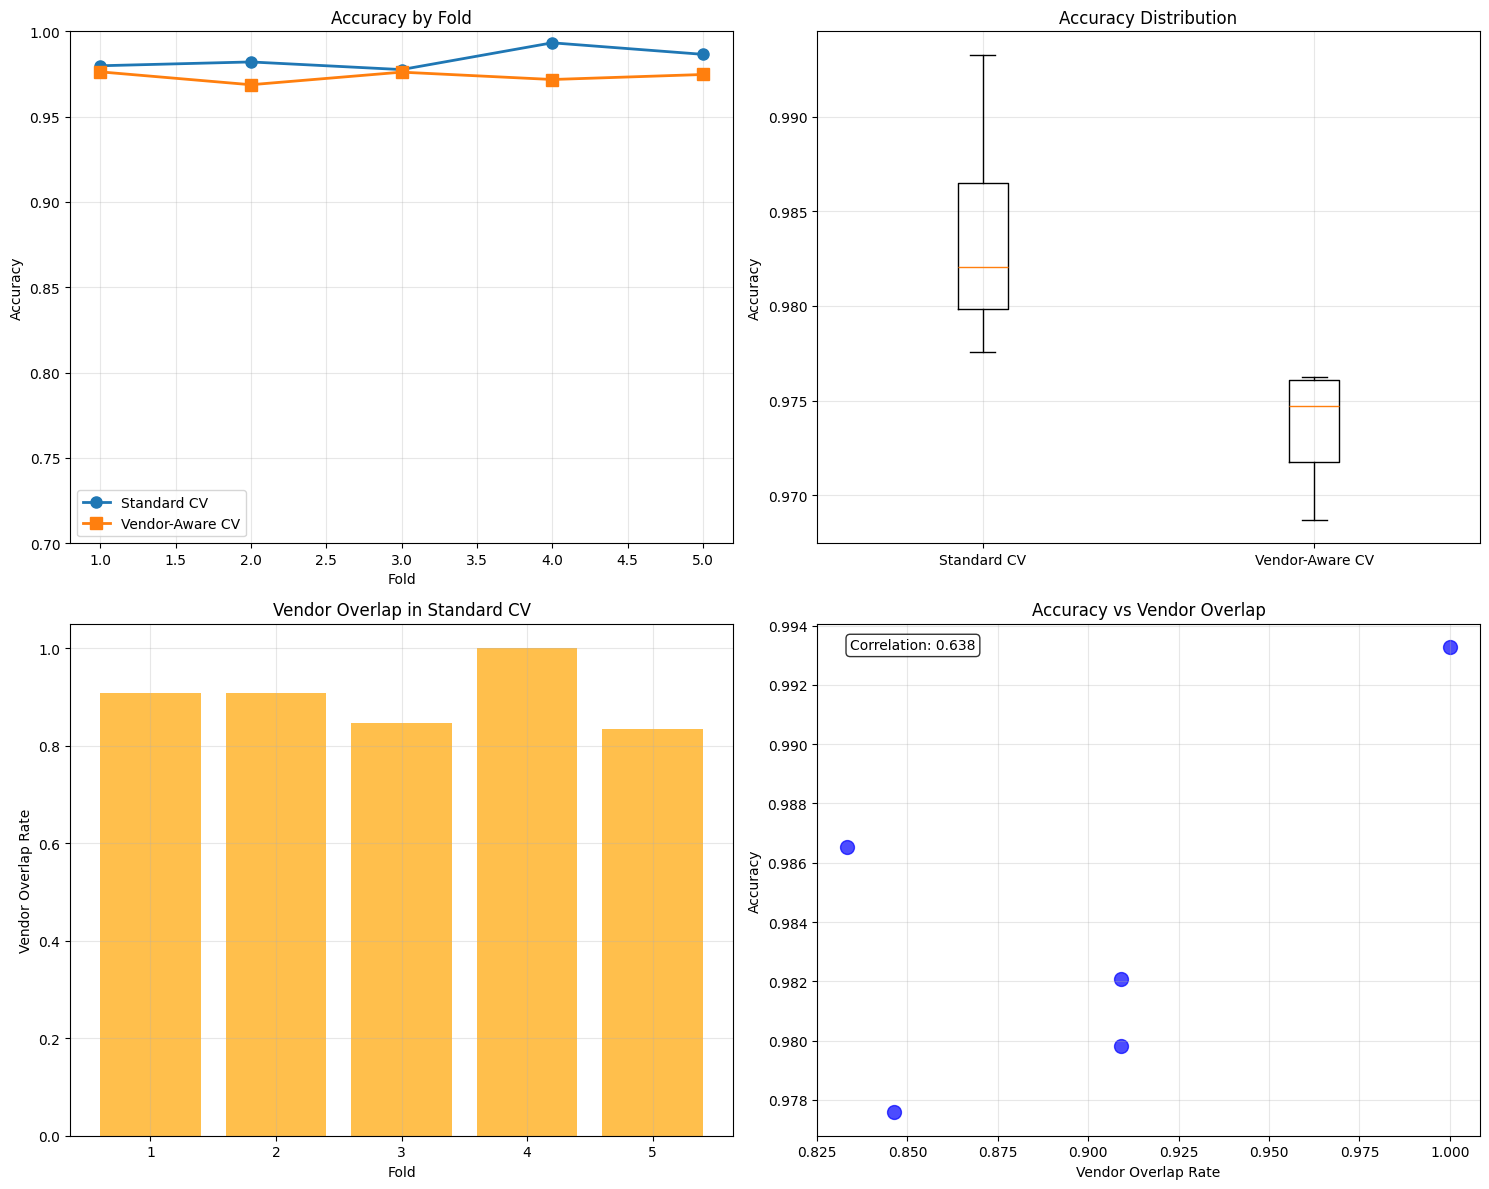


📊 VISUALIZATION INSIGHTS:
   • Accuracy correlation with vendor overlap: 0.638
   • Strong positive correlation suggests vendor-specific patterns


In [41]:
# Cell 8: Visualization
def plot_cv_comparison(cv_results):
    """
    Create visualizations comparing CV strategies
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    standard = cv_results['standard_cv']
    vendor_aware = cv_results['vendor_aware_cv']
    
    # 1. Accuracy comparison
    folds = range(1, len(standard['scores']) + 1)
    ax1.plot(folds, standard['scores'], 'o-', label='Standard CV', linewidth=2, markersize=8)
    ax1.plot(folds, vendor_aware['scores'], 's-', label='Vendor-Aware CV', linewidth=2, markersize=8)
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy by Fold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.7, 1.0)
    
    # 2. Box plot comparison
    data_to_plot = [standard['scores'], vendor_aware['scores']]
    labels = ['Standard CV', 'Vendor-Aware CV']
    ax2.boxplot(data_to_plot, labels=labels)
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Distribution')
    ax2.grid(True, alpha=0.3)
    
    # 3. Vendor overlap analysis
    overlap_rates = [d['overlap_rate'] for d in standard['details']]
    ax3.bar(folds, overlap_rates, alpha=0.7, color='orange')
    ax3.set_xlabel('Fold')
    ax3.set_ylabel('Vendor Overlap Rate')
    ax3.set_title('Vendor Overlap in Standard CV')
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance vs Overlap
    overlap_rates = [d['overlap_rate'] for d in standard['details']]
    standard_accs = standard['scores']
    ax4.scatter(overlap_rates, standard_accs, s=100, alpha=0.7, color='blue')
    ax4.set_xlabel('Vendor Overlap Rate')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Accuracy vs Vendor Overlap')
    ax4.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = np.corrcoef(overlap_rates, standard_accs)[0,1]
    ax4.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax4.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Summary interpretation
    print(f"\n📊 VISUALIZATION INSIGHTS:")
    print(f"   • Accuracy correlation with vendor overlap: {corr:.3f}")
    if corr > 0.5:
        print(f"   • Strong positive correlation suggests vendor-specific patterns")
    elif corr > 0.2:
        print(f"   • Moderate correlation suggests some vendor influence")
    else:
        print(f"   • Weak correlation suggests vendor-agnostic features")

# Create visualizations
plot_cv_comparison(cv_results)


## Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
                feature  importance
  fp_approach_diversity    0.219769
         uses_canvas_fp    0.108527
   collection_intensity    0.100366
     tracks_coordinates    0.087336
        complexity_tier    0.085634
         uses_screen_fp    0.073319
   sophistication_score    0.049511
  interaction_diversity    0.039631
   tracks_device_motion    0.034089
         fp_focus_ratio    0.032369
behavioral_access_ratio    0.031659
           tracks_mouse    0.028991
 behavioral_focus_ratio    0.028818
          uses_audio_fp    0.019639
          tracks_timing    0.013811


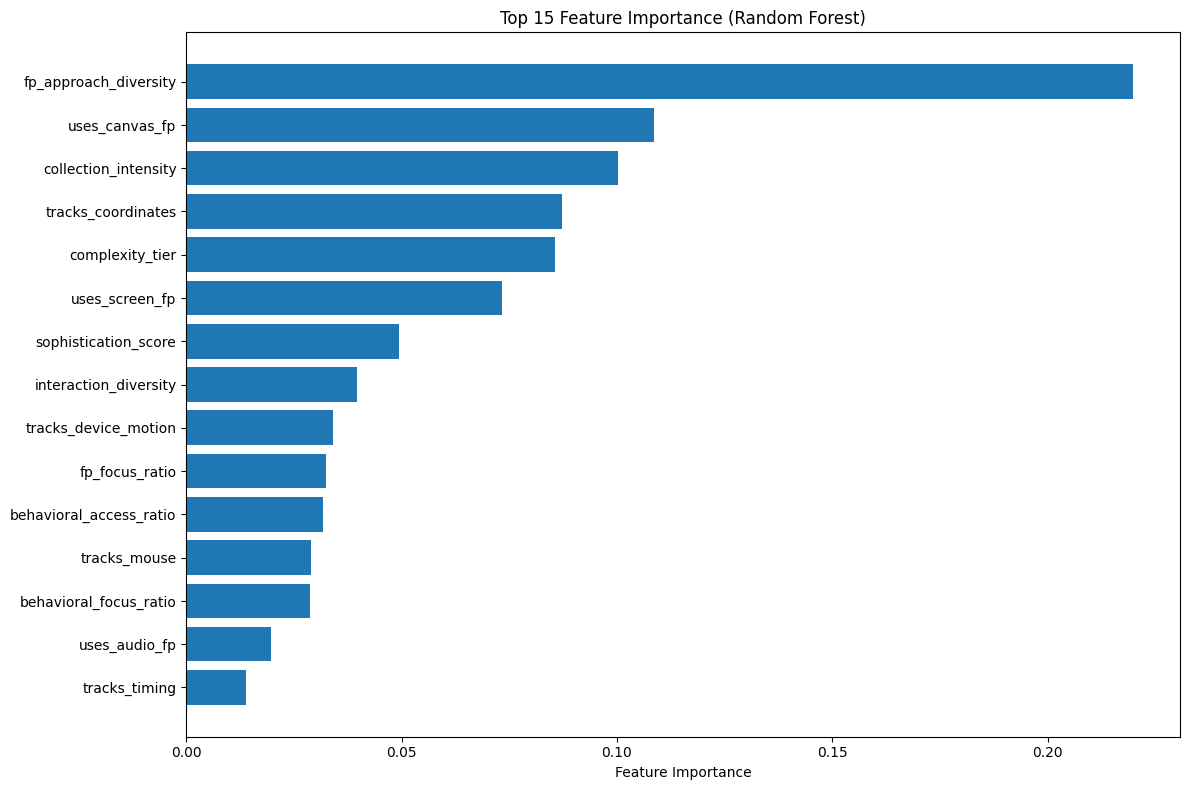

In [42]:
# Cell 9: Feature Importance Analysis
def analyze_feature_importance(features_df, feature_cols):
    """
    Analyze which features are most important for classification
    """
    print("="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    X = features_df[feature_cols]
    y = features_df['label']
    
    # Calculate proper class weights
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    # Train a model on all data to get feature importance
    rf_full = RandomForestClassifier(
        n_estimators=200, 
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, 
        class_weight=class_weight_dict
    )
    
    rf_full.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_full.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Analyze feature importance
feature_importance = analyze_feature_importance(features_df, feature_cols)


## Model Evaluation Summary

In [43]:
# Cell 10: Summary and Recommendations
def generate_recommendations(cv_results, performance_diff, dataset_info):
    """
    Generate recommendations based on CV comparison results
    """
    print("="*70)
    print("RECOMMENDATIONS AND NEXT STEPS")
    print("="*70)
    
    standard_acc = cv_results['standard_cv']['mean_accuracy']
    vendor_acc = cv_results['vendor_aware_cv']['mean_accuracy']
    standard_overlap = cv_results['standard_cv']['mean_overlap_rate']
    
    print(f"📊 RESULTS SUMMARY:")
    print(f"   Standard CV accuracy: {standard_acc:.3f}")
    print(f"   Vendor-aware CV accuracy: {vendor_acc:.3f}")
    print(f"   Performance gap: {performance_diff:.3f}")
    print(f"   Average vendor overlap in standard CV: {standard_overlap:.3f}")
    
    print(f"\n🎯 INTERPRETATION:")
    
    if performance_diff > 0.05:
        print("⚠️  SIGNIFICANT PERFORMANCE GAP (>0.05)")
        print("   • Standard CV is overly optimistic due to vendor overlap")
        print("   • Model is learning vendor-specific patterns")
        print("   • Real-world performance on new vendors will be closer to vendor-aware CV")
        
        print(f"\n🔧 RECOMMENDED ACTIONS:")
        print("   1. Use vendor-aware CV for model selection and evaluation")
        print("   2. Focus on improving cross-vendor generalization")
        print("   3. Consider collecting more diverse training data")
        print("   4. Investigate vendor-specific feature engineering")
        
    elif performance_diff > 0.02:
        print("⚠️  MODERATE PERFORMANCE GAP (0.02-0.05)")
        print("   • Some vendor-specific learning is occurring")
        print("   • Features are partially vendor-agnostic")
        print("   • Room for improvement in generalization")
        
        print(f"\n🔧 RECOMMENDED ACTIONS:")
        print("   1. Use vendor-aware CV for final evaluation")
        print("   2. Feature engineering to reduce vendor bias")
        print("   3. Consider ensemble methods")
        
    else:
        print("✅ MINIMAL PERFORMANCE GAP (<0.02)")
        print("   • Features are largely vendor-agnostic")
        print("   • Good cross-vendor generalization")
        print("   • Both CV strategies are valid")
        
        print(f"\n🔧 RECOMMENDED ACTIONS:")
        print("   1. Either CV strategy is acceptable")
        print("   2. Focus on hyperparameter tuning")
        print("   3. Consider more complex models")
    
    # Data-specific recommendations
    print(f"\n📈 DATA-SPECIFIC RECOMMENDATIONS:")
    
    if 'high_volume_vendors' in dataset_info:
        high_vol = len(dataset_info['high_volume_vendors'])
        medium_vol = len(dataset_info['medium_volume_vendors'])
        low_vol = len(dataset_info['low_volume_vendors'])
        
        print(f"   • High-volume vendors ({high_vol}): Well represented")
        print(f"   • Medium-volume vendors ({medium_vol}): Moderate representation")
        print(f"   • Low-volume vendors ({low_vol}): Limited representation")
        
        if low_vol > high_vol:
            print("   ⚠️  Many low-volume vendors - consider data augmentation")
        
        if high_vol < 3:
            print("   ⚠️  Few high-volume vendors - collect more data from major vendors")
    
    print(f"\n🔬 MODEL OPTIMIZATION PRIORITIES:")
    print("   1. Hyperparameter tuning (next step)")
    print("   2. Feature selection based on importance analysis")
    print("   3. Alternative algorithms (XGBoost, SVM, etc.)")
    print("   4. Ensemble methods")
    print("   5. Advanced cross-validation strategies")

# Generate recommendations
generate_recommendations(cv_results, performance_diff, dataset_info)

RECOMMENDATIONS AND NEXT STEPS
📊 RESULTS SUMMARY:
   Standard CV accuracy: 0.984
   Vendor-aware CV accuracy: 0.974
   Performance gap: 0.010
   Average vendor overlap in standard CV: 0.900

🎯 INTERPRETATION:
✅ MINIMAL PERFORMANCE GAP (<0.02)
   • Features are largely vendor-agnostic
   • Good cross-vendor generalization
   • Both CV strategies are valid

🔧 RECOMMENDED ACTIONS:
   1. Either CV strategy is acceptable
   2. Focus on hyperparameter tuning
   3. Consider more complex models

📈 DATA-SPECIFIC RECOMMENDATIONS:
   • High-volume vendors (4): Well represented
   • Medium-volume vendors (5): Moderate representation
   • Low-volume vendors (9): Limited representation
   ⚠️  Many low-volume vendors - consider data augmentation

🔬 MODEL OPTIMIZATION PRIORITIES:
   1. Hyperparameter tuning (next step)
   2. Feature selection based on importance analysis
   3. Alternative algorithms (XGBoost, SVM, etc.)
   4. Ensemble methods
   5. Advanced cross-validation strategies


## Detailed Error Analysis

In [44]:
# Cell 11: Detailed Error Analysis
def detailed_error_analysis(features_df, feature_cols, n_splits=3):
    """
    Perform detailed error analysis to understand where models fail
    """
    print("="*70)
    print("DETAILED ERROR ANALYSIS")
    print("="*70)
    
    X = features_df[feature_cols]
    y = features_df['label']
    
    # Calculate proper class weights
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    base_model = RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, class_weight=class_weight_dict
    )
    
    # Vendor-aware CV for error analysis
    vendor_cv = VendorAwareCV(n_splits=n_splits, random_state=42)
    
    all_errors = []
    all_correct = []
    
    for fold, (train_idx, val_idx) in enumerate(vendor_cv.split(X, y, features_df[['vendor']])):
        print(f"\nAnalyzing Fold {fold + 1}...")
        
        # Train model
        model = clone(base_model)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        
        # Predict
        y_pred = model.predict(X.iloc[val_idx])
        y_proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        
        # Create results dataframe
        val_results = features_df.iloc[val_idx].copy()
        val_results['predicted'] = y_pred
        val_results['probability'] = y_proba
        val_results['correct'] = (val_results['predicted'] == val_results['label'])
        val_results['fold'] = fold + 1
        
        # Separate errors and correct predictions
        errors = val_results[~val_results['correct']]
        correct = val_results[val_results['correct']]
        
        all_errors.append(errors)
        all_correct.append(correct)
        
        # Fold-specific analysis
        print(f"  Total predictions: {len(val_results)}")
        print(f"  Correct: {len(correct)} ({len(correct)/len(val_results)*100:.1f}%)")
        print(f"  Errors: {len(errors)} ({len(errors)/len(val_results)*100:.1f}%)")
        
        if len(errors) > 0:
            # Error breakdown
            false_positives = errors[errors['label'] == 0]
            false_negatives = errors[errors['label'] == 1]
            
            print(f"    False Positives: {len(false_positives)}")
            print(f"    False Negatives: {len(false_negatives)}")
            
            # Vendor-specific errors for false negatives
            if len(false_negatives) > 0:
                vendor_errors = false_negatives['vendor'].value_counts()
                print(f"    FN by Vendor: {dict(vendor_errors)}")
    
    # Combine all folds
    all_errors_df = pd.concat(all_errors, ignore_index=True) if all_errors else pd.DataFrame()
    all_correct_df = pd.concat(all_correct, ignore_index=True) if all_correct else pd.DataFrame()
    
    if len(all_errors_df) > 0:
        print(f"\n🔍 OVERALL ERROR PATTERNS:")
        
        # False positive analysis
        false_positives = all_errors_df[all_errors_df['label'] == 0]
        false_negatives = all_errors_df[all_errors_df['label'] == 1]
        
        print(f"Total False Positives: {len(false_positives)}")
        print(f"Total False Negatives: {len(false_negatives)}")
        
        if len(false_negatives) > 0:
            print(f"\nFalse Negatives by Vendor:")
            fn_by_vendor = false_negatives['vendor'].value_counts()
            for vendor, count in fn_by_vendor.items():
                total_vendor = len(features_df[(features_df['vendor'] == vendor) & (features_df['label'] == 1)])
                error_rate = count / total_vendor if total_vendor > 0 else 0
                print(f"  {vendor}: {count} errors ({error_rate*100:.1f}% of vendor's scripts)")
        
        # Feature analysis for errors
        print(f"\n📊 FEATURE ANALYSIS FOR ERRORS:")
        
        # Compare feature distributions between errors and correct predictions
        if len(all_correct_df) > 0:
            for feature in feature_cols[:10]:  # Analyze top 10 features
                error_mean = all_errors_df[feature].mean()
                correct_mean = all_correct_df[feature].mean()
                difference = error_mean - correct_mean
                
                if abs(difference) > 0.1:  # Significant difference
                    print(f"  {feature}: Error={error_mean:.3f}, Correct={correct_mean:.3f}, "
                          f"Diff={difference:.3f}")
    
    return all_errors_df, all_correct_df

# Run detailed error analysis (using fewer folds for speed)
errors_df, correct_df = detailed_error_analysis(features_df, feature_cols, n_splits=3)

DETAILED ERROR ANALYSIS
Vendor categories for CV:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']

Analyzing Fold 1...
  Total predictions: 674
  Correct: 658 (97.6%)
  Errors: 16 (2.4%)
    False Positives: 5
    False Negatives: 11
    FN by Vendor: {'Sardine': np.int64(3), 'Accertify': np.int64(3), 'Human': np.int64(2), 'Transmit': np.int64(2), 'Callsign': np.int64(1)}

Analyzing Fold 2...
  Total predictions: 671
  Correct: 650 (96.9%)
  Errors: 21 (3.1%)
    False Positives: 6
    False Negatives: 15
    FN by Vendor: {'Sardine': np.int64(6), 'Cheq': np.int64(4), 'Human': np.int64(2), 'Transmit': np.int64(2), 'Callsign': np.int64(1)}

Analyzing Fold 3...
  Total predictions: 669
  Correct: 653 (97.6%)
  Errors: 16 (2.4%)
    False Positives: 3
    False Negatives: 

In [45]:
# Cell 12: Model Confidence Analysis
def analyze_model_confidence(features_df, feature_cols):
    """
    Analyze model confidence patterns
    """
    print("="*60)
    print("MODEL CONFIDENCE ANALYSIS")
    print("="*60)
    
    X = features_df[feature_cols]
    y = features_df['label']
    
    # Calculate proper class weights
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    # Train on full dataset for confidence analysis
    model = RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, class_weight=class_weight_dict
    )
    
    model.fit(X, y)
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)
    
    # Add predictions to dataframe
    analysis_df = features_df.copy()
    analysis_df['probability'] = y_proba
    analysis_df['predicted'] = y_pred
    analysis_df['correct'] = (analysis_df['predicted'] == analysis_df['label'])
    
    # Confidence analysis by vendor
    positive_df = analysis_df[analysis_df['label'] == 1]
    
    print("Confidence Analysis by Vendor:")
    print(f"{'Vendor':<15} {'Count':<8} {'Avg Conf':<10} {'Min Conf':<10} {'Max Conf':<10}")
    print("-" * 60)
    
    vendor_confidence = {}
    for vendor in sorted(positive_df['vendor'].unique()):
        if vendor != 'negative' and vendor != 'unknown':
            vendor_data = positive_df[positive_df['vendor'] == vendor]
            
            avg_conf = vendor_data['probability'].mean()
            min_conf = vendor_data['probability'].min()
            max_conf = vendor_data['probability'].max()
            count = len(vendor_data)
            
            vendor_confidence[vendor] = {
                'avg': avg_conf,
                'min': min_conf,
                'max': max_conf,
                'count': count
            }
            
            print(f"{vendor:<15} {count:<8} {avg_conf:<10.3f} {min_conf:<10.3f} {max_conf:<10.3f}")
    
    # Low confidence samples (potential issues)
    low_confidence_threshold = 0.6
    low_conf_positives = positive_df[positive_df['probability'] < low_confidence_threshold]
    
    if len(low_conf_positives) > 0:
        print(f"\n⚠️  LOW CONFIDENCE POSITIVE SAMPLES (< {low_confidence_threshold}):")
        print(f"Total: {len(low_conf_positives)}")
        
        low_conf_by_vendor = low_conf_positives['vendor'].value_counts()
        for vendor, count in low_conf_by_vendor.items():
            total_vendor = len(positive_df[positive_df['vendor'] == vendor])
            percentage = count / total_vendor * 100
            print(f"  {vendor}: {count}/{total_vendor} ({percentage:.1f}%)")
    
    # High confidence analysis
    high_confidence_threshold = 0.9
    high_conf_positives = positive_df[positive_df['probability'] > high_confidence_threshold]
    
    print(f"\n✅ HIGH CONFIDENCE POSITIVE SAMPLES (> {high_confidence_threshold}):")
    print(f"Total: {len(high_conf_positives)}/{len(positive_df)} ({len(high_conf_positives)/len(positive_df)*100:.1f}%)")
    
    return vendor_confidence, low_conf_positives, high_conf_positives

# Analyze model confidence
vendor_conf, low_conf, high_conf = analyze_model_confidence(features_df, feature_cols)


MODEL CONFIDENCE ANALYSIS
Confidence Analysis by Vendor:
Vendor          Count    Avg Conf   Min Conf   Max Conf  
------------------------------------------------------------
Accertify       3        0.837      0.827      0.843     
Behaviosec      9        0.974      0.900      0.994     
BioCatch        21       0.973      0.813      0.999     
Callsign        1        0.723      0.723      0.723     
Cheq            4        0.818      0.760      0.883     
Datadome        1        0.891      0.891      0.891     
Feedzai         2        0.746      0.714      0.778     
Forter          53       0.983      0.577      1.000     
GroupIB         1        0.804      0.804      0.804     
Human           27       0.889      0.491      0.999     
Iovation        81       0.991      0.645      1.000     
Nudata          6        0.745      0.593      0.901     
PingOne         5        0.992      0.990      0.993     
Sardine         6        0.844      0.579      0.942     
Threatmark  

# Final Summary

In [46]:
# Cell 13: Final Summary and Next Steps
def final_summary_and_next_steps(cv_results, performance_diff, feature_importance):
    """
    Provide final summary and concrete next steps
    """
    print("="*80)
    print("FINAL SUMMARY AND ACTIONABLE NEXT STEPS")
    print("="*80)
    
    # Performance summary
    print("🎯 PERFORMANCE SUMMARY:")
    print(f"   Standard CV: {cv_results['standard_cv']['mean_accuracy']:.3f} ± {cv_results['standard_cv']['std_accuracy']:.3f}")
    print(f"   Vendor-Aware CV: {cv_results['vendor_aware_cv']['mean_accuracy']:.3f} ± {cv_results['vendor_aware_cv']['std_accuracy']:.3f}")
    print(f"   Performance Gap: {performance_diff:.3f}")
    
    # Model readiness assessment
    vendor_aware_acc = cv_results['vendor_aware_cv']['mean_accuracy']
    
    print(f"\n📊 MODEL READINESS ASSESSMENT:")
    if vendor_aware_acc >= 0.95:
        print("🟢 EXCELLENT - Model is production-ready")
        priority = "hyperparameter tuning and deployment preparation"
    elif vendor_aware_acc >= 0.90:
        print("🟡 GOOD - Model needs minor improvements")
        priority = "feature engineering and hyperparameter optimization"
    elif vendor_aware_acc >= 0.85:
        print("🟠 MODERATE - Model needs significant improvements")
        priority = "data collection and feature engineering"
    else:
        print("🔴 POOR - Model needs major improvements")
        priority = "data collection and algorithm exploration"
    
    print(f"   Primary Focus: {priority}")
    
    # Concrete next steps
    print(f"\n🚀 IMMEDIATE NEXT STEPS (Priority Order):")
    
    steps = []
    
    if performance_diff > 0.05:
        steps.append("1. Address vendor bias - Use vendor-aware CV for all evaluations")
        steps.append("2. Feature engineering - Create more vendor-agnostic features")
    
    if vendor_aware_acc < 0.90:
        steps.append(f"{len(steps)+1}. Data collection - Gather more diverse vendor samples")
    
    steps.append(f"{len(steps)+1}. Hyperparameter tuning - Optimize Random Forest parameters")
    steps.append(f"{len(steps)+1}. Algorithm comparison - Test XGBoost, SVM, Neural Networks")
    steps.append(f"{len(steps)+1}. Feature selection - Use top {min(15, len(feature_importance))} most important features")
    steps.append(f"{len(steps)+1}. Ensemble methods - Combine multiple models")
    
    for step in steps:
        print(f"   {step}")
    
    # Feature recommendations
    top_features = feature_importance.head(10)['feature'].tolist()
    print(f"\n🔧 FEATURE ENGINEERING RECOMMENDATIONS:")
    print(f"   • Focus on top features: {', '.join(top_features[:5])}")
    print(f"   • Remove low-importance features (importance < 0.01)")
    print(f"   • Consider feature interactions and polynomial features")
    
    # Code templates for next steps
    print(f"\n💻 READY-TO-USE CODE TEMPLATES:")
    print(f"   Run these cells next for immediate improvements:")
    
    print(f"""
# Hyperparameter Tuning Template:
from sklearn.model_selection import GridSearchCV
param_grid = {{
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}}
# Use vendor_aware_cv for scoring!

# Alternative Algorithm Template:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
# Test with same CV strategy

# Feature Selection Template:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X, y)
""")

    return {
        'readiness_level': vendor_aware_acc,
        'priority_actions': steps,
        'top_features': top_features
    }

# Generate final summary
final_results = final_summary_and_next_steps(cv_results, performance_diff, feature_importance)

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE!")
print("="*80)
print("✅ All analyses completed successfully")
print("📋 Results saved in variables: cv_results, feature_importance, final_results")
print("🎯 Ready for hyperparameter tuning and model optimization")
print("="*80)

FINAL SUMMARY AND ACTIONABLE NEXT STEPS
🎯 PERFORMANCE SUMMARY:
   Standard CV: 0.984 ± 0.006
   Vendor-Aware CV: 0.974 ± 0.003
   Performance Gap: 0.010

📊 MODEL READINESS ASSESSMENT:
🟢 EXCELLENT - Model is production-ready
   Primary Focus: hyperparameter tuning and deployment preparation

🚀 IMMEDIATE NEXT STEPS (Priority Order):
   1. Hyperparameter tuning - Optimize Random Forest parameters
   2. Algorithm comparison - Test XGBoost, SVM, Neural Networks
   3. Feature selection - Use top 15 most important features
   4. Ensemble methods - Combine multiple models

🔧 FEATURE ENGINEERING RECOMMENDATIONS:
   • Focus on top features: fp_approach_diversity, uses_canvas_fp, collection_intensity, tracks_coordinates, complexity_tier
   • Remove low-importance features (importance < 0.01)
   • Consider feature interactions and polynomial features

💻 READY-TO-USE CODE TEMPLATES:
   Run these cells next for immediate improvements:

# Hyperparameter Tuning Template:
from sklearn.model_selection i